In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
if '..' not in sys.path: sys.path.append('..')
from f_ring_util import (compute_corrected_ew, 
                         fit_hg_phase_function, 
                         hg_func,
                         print_hg_params)

In [2]:
# Read the data and dump statistics

orig_obsdata = pd.read_csv('../data_files/good_qual_full.csv', parse_dates=['Date']); ms=20; alpha=0.7
# orig_obsdata = pd.read_csv('../data_files/good_qual_1deg.csv', parse_dates=['Date']); ms=4; alpha=0.1
print('** SUMMARY STATISTICS **')
print('Unique observation names:', len(orig_obsdata.groupby('Observation')))
print('Total slices:', len(orig_obsdata))
print('Starting date:', orig_obsdata['Date'].min())
print('Ending date:', orig_obsdata['Date'].max())
print('Time span:', orig_obsdata['Date'].max()-orig_obsdata['Date'].min())

good_i = np.abs(orig_obsdata['Incidence']-90) > 0.5
obsdata = orig_obsdata[good_i]
print('Removed OBSIDs:', set(orig_obsdata[~good_i].groupby('Observation').indices))
print('Final unique observation names:', len(obsdata))

** SUMMARY STATISTICS **
Unique observation names: 152
Total slices: 152
Starting date: 2004-06-20 20:03:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 15:43:39
Removed OBSIDs: {'ISS_115RF_FMOVIEEQX001_PRIME', 'ISS_114RF_FMOVIEEQX001_PRIME'}
Final unique observation names: 150


# Optimize Tau for Low-Phase Observations

In [3]:
# Find "small" (<6) e or i

low_phase_mask = obsdata['Mean Phase'] <= 60
low_phase_obsdata = obsdata[low_phase_mask]
lp_low_e_mask = np.abs(low_phase_obsdata['Mean Emission']-90) < 6
lp_low_i_mask = np.abs(low_phase_obsdata['Incidence']-90) < 6
lp_low_ei_mask = lp_low_e_mask | lp_low_i_mask

low_e_mask = np.abs(obsdata['Mean Emission']-90) < 6
low_i_mask = np.abs(obsdata['Incidence']-90) < 6
low_ei_mask = low_e_mask | low_i_mask

Tau 0.000 - Mean Normal EW Low E/I:  0.52893 EW Other:  0.57934 Ratio: 1.095
Tau 0.001 - Mean Normal EW Low E/I:  0.53524 EW Other:  0.58126 Ratio: 1.086
Tau 0.002 - Mean Normal EW Low E/I:  0.54163 EW Other:  0.58319 Ratio: 1.077
Tau 0.003 - Mean Normal EW Low E/I:  0.54811 EW Other:  0.58512 Ratio: 1.068
Tau 0.004 - Mean Normal EW Low E/I:  0.55467 EW Other:  0.58705 Ratio: 1.058
Tau 0.005 - Mean Normal EW Low E/I:  0.56132 EW Other:  0.58900 Ratio: 1.049
Tau 0.006 - Mean Normal EW Low E/I:  0.56805 EW Other:  0.59095 Ratio: 1.040
Tau 0.007 - Mean Normal EW Low E/I:  0.57487 EW Other:  0.59290 Ratio: 1.031
Tau 0.008 - Mean Normal EW Low E/I:  0.58178 EW Other:  0.59487 Ratio: 1.023
Tau 0.009 - Mean Normal EW Low E/I:  0.58877 EW Other:  0.59684 Ratio: 1.014
Tau 0.010 - Mean Normal EW Low E/I:  0.59585 EW Other:  0.59881 Ratio: 1.005
Tau 0.011 - Mean Normal EW Low E/I:  0.60302 EW Other:  0.60079 Ratio: 0.996
Tau 0.012 - Mean Normal EW Low E/I:  0.61028 EW Other:  0.60278 Ratio: 0.988

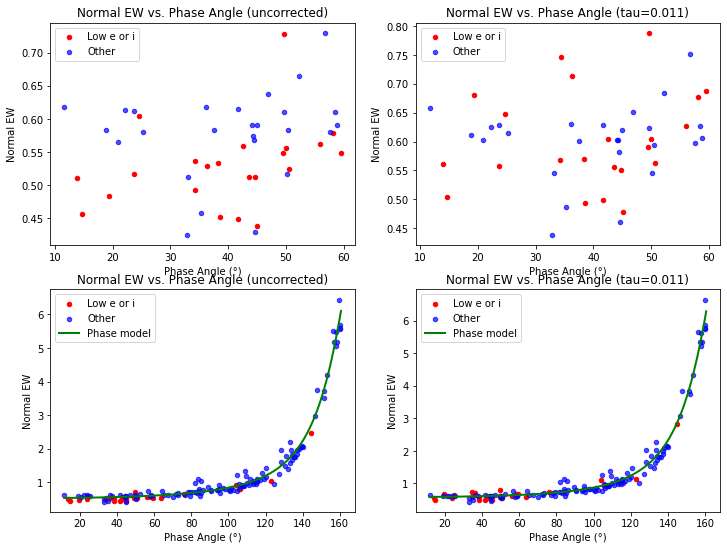

In [4]:
# Find the optimal tau to minimize scatter

best_tau = None
best_ratio = 1e38
for tau in np.arange(0.000, 0.021, 0.001):
    corrected_ew = compute_corrected_ew(low_phase_obsdata['Normal EW'], 
                                        low_phase_obsdata['Mean Emission'], 
                                        low_phase_obsdata['Incidence'], 
                                        tau=tau)
    mean_low = np.mean(corrected_ew[lp_low_ei_mask])
    mean_notlow = np.mean(corrected_ew[~lp_low_ei_mask])
    if abs(mean_notlow/mean_low-1) < best_ratio:
        best_ratio = abs(mean_notlow/mean_low-1)
        best_tau = tau
    if abs(mean_low/mean_notlow-1) < best_ratio:
        best_ratio = abs(mean_low/mean_notlow-1)
        best_tau = tau
    print(f'Tau {tau:.3f} - Mean Normal EW Low E/I: {mean_low:8.5f} '
          f'EW Other: {mean_notlow:8.5f} '
          f'Ratio: {mean_notlow/mean_low:5.3f}')
print()
print(f'** Best Tau: {best_tau:.3f}')

print()
print('Uncorrected Low Phase:')
uc_mean_low = np.mean(low_phase_obsdata['Normal EW'][lp_low_ei_mask])
uc_mean_notlow = np.mean(low_phase_obsdata['Normal EW'][~lp_low_ei_mask])
print(f'Mean Normal EW Low E/I: {uc_mean_low:.5f}')
print(f'Mean Normal EW Other:   {uc_mean_notlow:.5f}')
print(f'Other/Low: {uc_mean_notlow/uc_mean_low:.5f}')
print()

lp_corrected_ew = compute_corrected_ew(low_phase_obsdata['Normal EW'], 
                                       low_phase_obsdata['Mean Emission'], 
                                       low_phase_obsdata['Incidence'], 
                                       tau=best_tau)
mean_low = np.mean(lp_corrected_ew[lp_low_ei_mask])
mean_notlow = np.mean(lp_corrected_ew[~lp_low_ei_mask])
print(f'Corrected (tau={best_tau:.3f}) Low Phase:')
print(f'Mean Normal EW Low E/I: {mean_low:.5f}')
print(f'Mean Normal EW Other:   {mean_notlow:.5f}')
print(f'Other/Low: {mean_notlow/mean_low:.5f}')

print()
print('Overall change due to Tau:')
print(f'Mean Normal EW Low E/I: {mean_low/uc_mean_low:.5f}')
print(f'Mean Normal EW Other:   {mean_notlow/uc_mean_notlow:.5f}')

# Find H-G phase curve for full dataset
corrected_ew = compute_corrected_ew(obsdata['Normal EW'], 
                                    obsdata['Mean Emission'], 
                                    obsdata['Incidence'], 
                                    tau=best_tau)

uc_hg_params, uc_hg_used_data, uc_hg_std = fit_hg_phase_function(2, None, obsdata, 
                                                                 verbose=False)
print()
print('Uncorrected H-G params:')
print_hg_params(uc_hg_params, indent=2)
print(f'  Standard deviation: {uc_hg_std:.5f}')

hg_params, hg_used_data, hg_std = fit_hg_phase_function(2, None, obsdata, 
                                                        tau=best_tau,
                                                        verbose=False)
print()
print(f'Corrected (tau={best_tau:.3f}) params:')
print_hg_params(hg_params, indent=2)
print(f'  Standard deviation: {hg_std:.5f}')

# Plot results
plt.figure(figsize=(12,9))
plt.subplot(2, 2, 1)
plt.scatter(low_phase_obsdata['Mean Phase'][lp_low_ei_mask], 
            low_phase_obsdata['Normal EW'][lp_low_ei_mask], 
            s=ms, c='red', label='Low e or i')
plt.scatter(low_phase_obsdata['Mean Phase'][~lp_low_ei_mask], 
            low_phase_obsdata['Normal EW'][~lp_low_ei_mask], 
            s=ms, alpha=alpha, c='blue', label='Other')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title('Normal EW vs. Phase Angle (uncorrected)')

plt.subplot(2, 2, 2)
plt.scatter(low_phase_obsdata['Mean Phase'][lp_low_ei_mask], 
            lp_corrected_ew[lp_low_ei_mask], 
            s=ms, c='red', label='Low e or i')
plt.scatter(low_phase_obsdata['Mean Phase'][~lp_low_ei_mask], 
            lp_corrected_ew[~lp_low_ei_mask], 
            s=ms, alpha=alpha, c='blue', label='Other')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title(f'Normal EW vs. Phase Angle (tau={best_tau:.3f})')

plt.subplot(2, 2, 3)
plt.scatter(obsdata['Mean Phase'][low_ei_mask], 
            obsdata['Normal EW'][low_ei_mask], 
            s=ms, c='red', label='Low e or i')
plt.scatter(obsdata['Mean Phase'][~low_ei_mask], 
            obsdata['Normal EW'][~low_ei_mask], 
            s=ms, alpha=alpha, c='blue', label='Other')
xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
uc_hg_phase_model = hg_func(uc_hg_params, np.radians(xrange))
plt.plot(xrange, uc_hg_phase_model, '-', color='green', lw=2, label='Phase model')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title('Normal EW vs. Phase Angle (uncorrected)')

plt.subplot(2, 2, 4)
plt.scatter(obsdata['Mean Phase'][low_ei_mask], 
            corrected_ew[low_ei_mask], 
            s=ms, c='red', label='Low e or i')
plt.scatter(obsdata['Mean Phase'][~low_ei_mask], 
            corrected_ew[~low_ei_mask], 
            s=ms, alpha=alpha, c='blue', label='Other')
xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
hg_phase_model = hg_func(hg_params, np.radians(xrange))
plt.plot(xrange, hg_phase_model, '-', color='green', lw=2, label='Phase model')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title(f'Normal EW vs. Phase Angle (tau={best_tau:.3f})')
plt.show()